In [111]:
import tensorflow_decision_forests as tfdf
import tensorflow as tf
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import warnings
warnings.filterwarnings("ignore")
import math

# Comment this if the data visualisations doesn't work on your side
%matplotlib inline



In [50]:
print("TensorFlow v" + tf.__version__)
print("TensorFlow Decision Forests v" + tfdf.__version__)

TensorFlow v2.13.0
TensorFlow Decision Forests v1.5.0


In [51]:
def predict_function(model, data):
  @tf.function(reduce_retracing=True)
  def inner_function(model, data):
    return model(data)

  return inner_function(model, data)

In [53]:
dataset = pd.read_csv("data/house-prices-advanced-regression-techniques/train.csv")
dataset.head()


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [54]:
tf_dataset = tfdf.keras.pd_dataframe_to_tf_dataset(dataset, label="SaleCondition")

model = tfdf.keras.RandomForestModel()
model.fit(tf_dataset)

print(model.summary())

Use /var/folders/7p/nhr_8mz933v_4r1mwyd3_jg40000gp/T/tmp7d0jrl8u as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.660350. Found 1460 examples.
Training model...
Model trained in 0:00:00.432528
Compiling model...


[INFO 23-09-03 12:08:51.2210 IST kernel.cc:1243] Loading model from path /var/folders/7p/nhr_8mz933v_4r1mwyd3_jg40000gp/T/tmp7d0jrl8u/model/ with prefix fe852d4580684905
[INFO 23-09-03 12:08:51.3208 IST decision_forest.cc:660] Model loaded with 300 root(s), 48650 node(s), and 77 input feature(s).
[INFO 23-09-03 12:08:51.3209 IST abstract_model.cc:1312] Engine "RandomForestGeneric" built
[INFO 23-09-03 12:08:51.3209 IST kernel.cc:1075] Use fast generic engine


Model compiled.
Model: "random_forest_model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
Total params: 1 (1.00 Byte)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 1 (1.00 Byte)
_________________________________________________________________
Type: "RANDOM_FOREST"
Task: CLASSIFICATION
Label: "__LABEL"

Input Features (80):
	1stFlrSF
	2ndFlrSF
	3SsnPorch
	Alley
	BedroomAbvGr
	BldgType
	BsmtCond
	BsmtExposure
	BsmtFinSF1
	BsmtFinSF2
	BsmtFinType1
	BsmtFinType2
	BsmtFullBath
	BsmtHalfBath
	BsmtQual
	BsmtUnfSF
	CentralAir
	Condition1
	Condition2
	Electrical
	EnclosedPorch
	ExterCond
	ExterQual
	Exterior1st
	Exterior2nd
	Fence
	FireplaceQu
	Fireplaces
	Foundation
	FullBath
	Functional
	GarageArea
	GarageCars
	GarageCond
	GarageFinish
	GarageQual
	GarageType
	GarageYrBlt
	GrLivArea
	HalfBath
	Heating
	HeatingQC
	HouseStyle
	Id
	KitchenAbvGr
	KitchenQual
	LandContour
	LandSlope
	LotArea
	LotConf

In [55]:
train_file_path = "data/house-prices-advanced-regression-techniques/train.csv"
dataset_df = pd.read_csv(train_file_path)
print("Full train dataset shape is {}".format(dataset_df.shape))

Full train dataset shape is (1460, 81)


In [56]:
dataset_df.head(3)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


In [59]:
# Get the first record.
first_record = dataset_df.iloc[0, :]

# Print the record vertically.
print(first_record)

Id                    1
MSSubClass           60
MSZoning             RL
LotFrontage        65.0
LotArea            8450
                  ...  
MoSold                2
YrSold             2008
SaleType             WD
SaleCondition    Normal
SalePrice        208500
Name: 0, Length: 81, dtype: object


In [12]:
dataset_df = dataset_df.drop('Id', axis=1)
dataset_df.head(3)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


In [13]:
dataset_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64


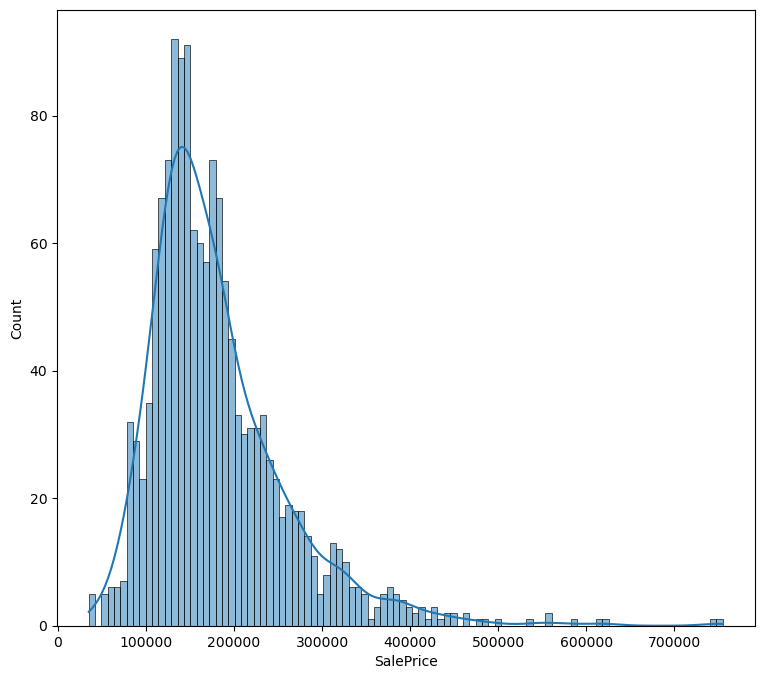

In [65]:
print(dataset_df['SalePrice'].describe())
plt.figure(figsize=(9, 8))
sns.histplot(dataset_df['SalePrice'], bins=100, kde=True);

In [15]:
list(set(dataset_df.dtypes.tolist()))

[dtype('float64'), dtype('int64'), dtype('O')]

In [16]:
df_num = dataset_df.select_dtypes(include = ['float64', 'int64'])
df_num.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,60,65.0,8450,7,5,2003,2003,196.0,706,0,...,0,61,0,0,0,0,0,2,2008,208500
1,20,80.0,9600,6,8,1976,1976,0.0,978,0,...,298,0,0,0,0,0,0,5,2007,181500
2,60,68.0,11250,7,5,2001,2002,162.0,486,0,...,0,42,0,0,0,0,0,9,2008,223500
3,70,60.0,9550,7,5,1915,1970,0.0,216,0,...,0,35,272,0,0,0,0,2,2006,140000
4,60,84.0,14260,8,5,2000,2000,350.0,655,0,...,192,84,0,0,0,0,0,12,2008,250000


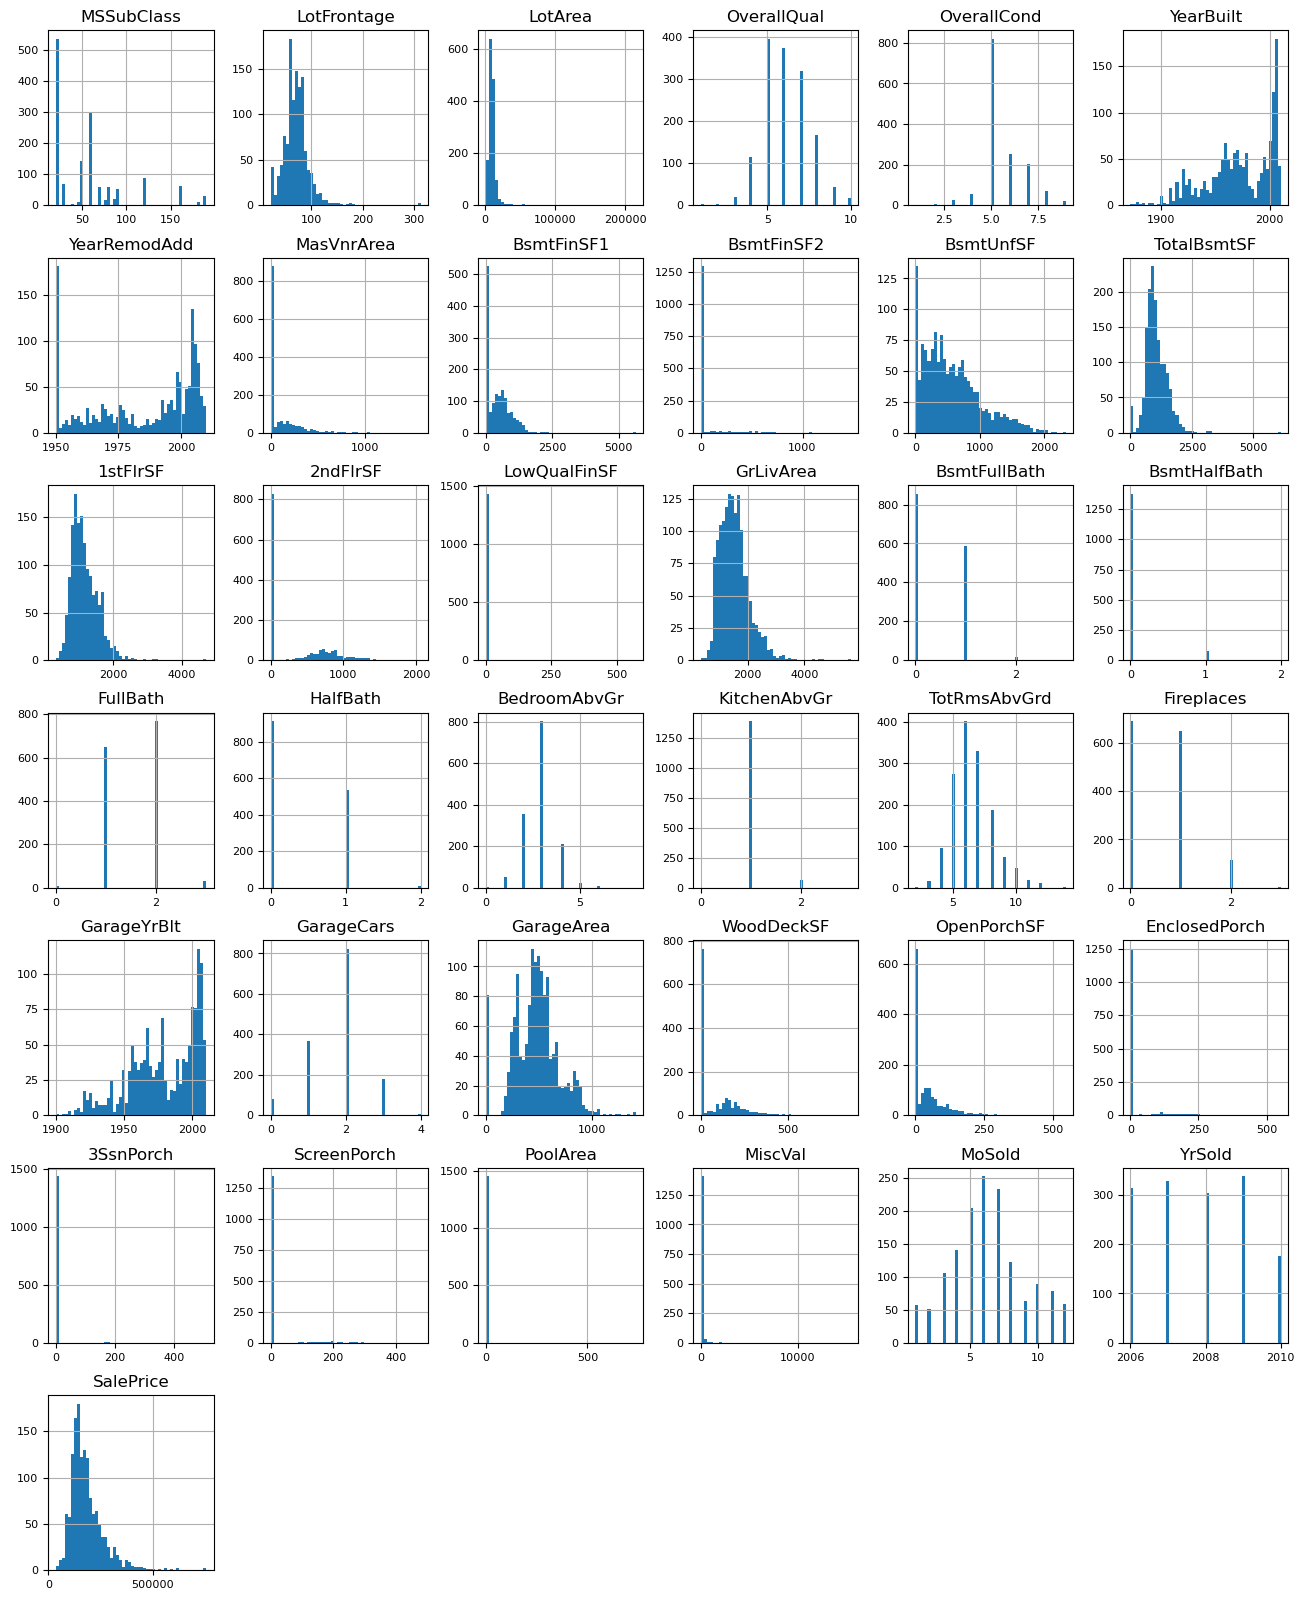

In [17]:
df_num.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8);

There are 19 columns with null values.
There are 19 columns with null values.
There are 2 rows.
There are 10 columns per graph.


IndexError: index 3 is out of bounds for axis 0 with size 2

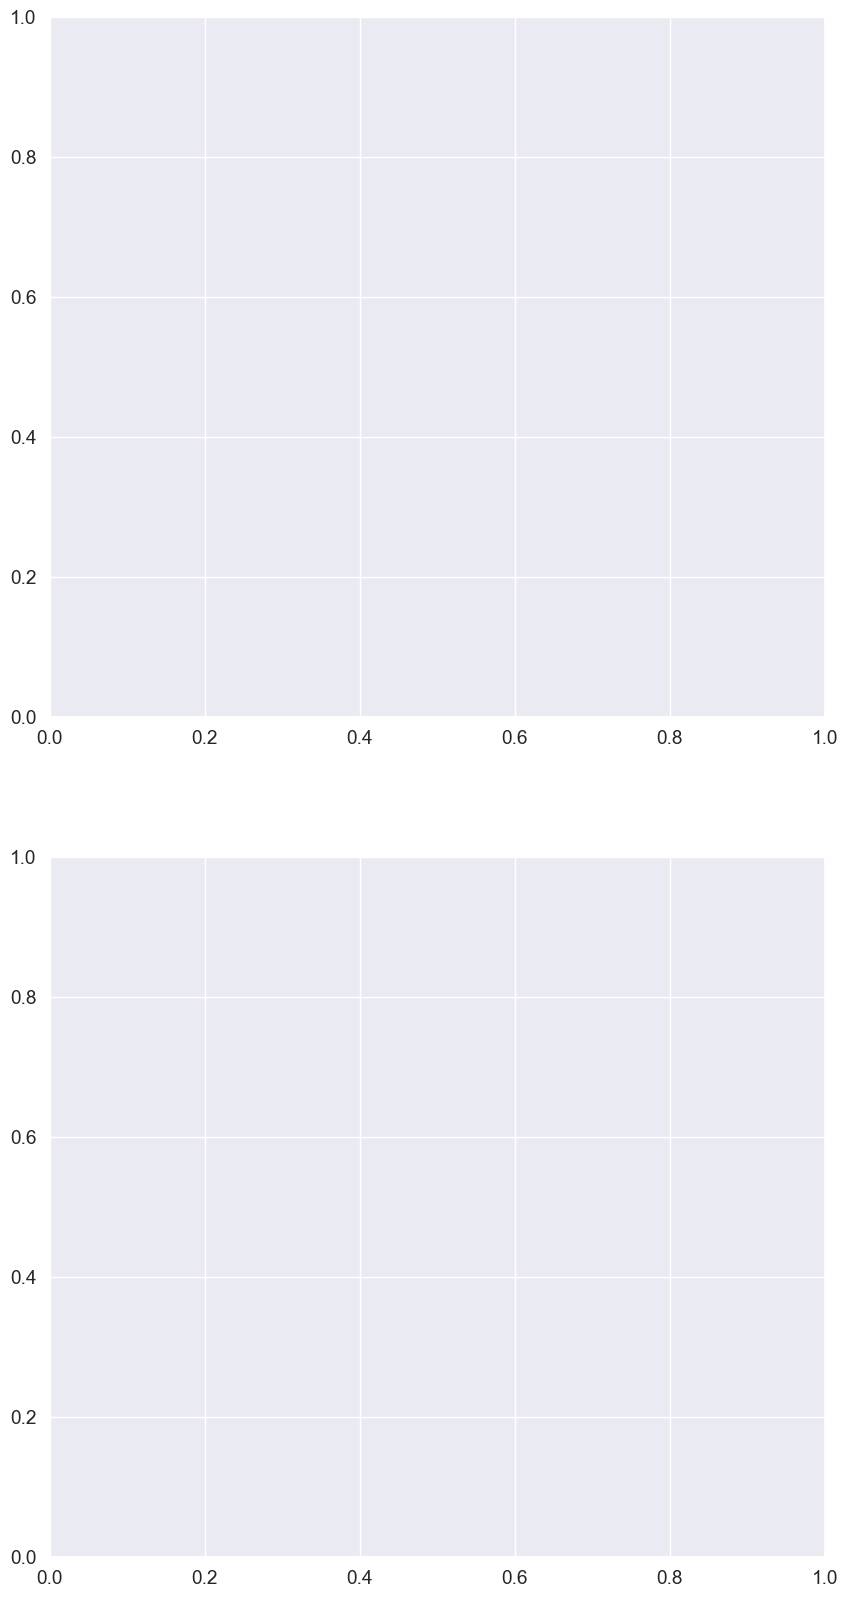

In [145]:
# # Get the indices of the columns with > 0 null values.
# null_cols = dataset.isnull().sum().index[dataset.isnull().sum() > 0]
# print(f"There are {len(null_cols)} columns with null values.")

# # Get the number of columns.
# n_cols = len(null_cols)
# print(f"There are {n_cols} columns with null values.")

# rows = math.ceil(n_cols / 10)
# print(f"There are {rows} rows.")

# # Divide the number of columns by 10 each in a row
# n_cols_per_graph = math.ceil(n_cols / rows)
# print(f"There are {n_cols_per_graph} columns per graph.")

# # Create  subplots.
# fig, axes = plt.subplots(nrows=rows, ncols=1, figsize=(n_cols_per_graph, 2 * n_cols_per_graph))

# # Plot the bar chart for each subplot.
# for i in range(n_cols):
#     if dataset.isnull().sum().iloc[i] > 0:
#         axes[i].bar(
#           null_cols[i * n_cols_per_graph:(i + 1) * n_cols_per_graph],
#           height=dataset.isnull().sum()[i * n_cols_per_graph:(i + 1) * n_cols_per_graph],
#         )

# # Adjust the spacing between the subplots.
# plt.subplots_adjust(bottom=0.2)

# # Tighten the layout.
# plt.tight_layout()

# # Set the font size of all the text in the figure.
# sns.set(font_scale=1.25)

# # Show the plot.
# plt.show()

In [66]:
def split_dataset(dataset, test_ratio=0.30):
  test_indices = np.random.rand(len(dataset)) < test_ratio
  return dataset[~test_indices], dataset[test_indices]

train_ds_pd, valid_ds_pd = split_dataset(dataset_df)
print("{} examples in training, {} examples in testing.".format(
    len(train_ds_pd), len(valid_ds_pd)))

995 examples in training, 465 examples in testing.


In [19]:
label = 'SalePrice'
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_ds_pd, label=label, task = tfdf.keras.Task.REGRESSION)
valid_ds = tfdf.keras.pd_dataframe_to_tf_dataset(valid_ds_pd, label=label, task = tfdf.keras.Task.REGRESSION)

Select a Model

There are several tree-based models for you to choose from.

RandomForestModel
GradientBoostedTreesModel
CartModel
DistributedGradientBoostedTreesModel

To start, we'll work with a Random Forest. This is the most well-known of the Decision Forest training algorithms.

A Random Forest is a collection of decision trees, each trained independently on a random subset of the training dataset (sampled with replacement). The algorithm is unique in that it is robust to overfitting, and easy to use.

We can list the all the available models in TensorFlow Decision Forests using the following code:

In [20]:
tfdf.keras.get_all_models()

[tensorflow_decision_forests.keras.RandomForestModel,
 tensorflow_decision_forests.keras.GradientBoostedTreesModel,
 tensorflow_decision_forests.keras.CartModel,
 tensorflow_decision_forests.keras.DistributedGradientBoostedTreesModel]

In [21]:
rf = tfdf.keras.RandomForestModel(hyperparameter_template="benchmark_rank1", task=tfdf.keras.Task.REGRESSION)

Resolve hyper-parameter template "benchmark_rank1" to "benchmark_rank1@v1" -> {'winner_take_all': True, 'categorical_algorithm': 'RANDOM', 'split_axis': 'SPARSE_OBLIQUE', 'sparse_oblique_normalization': 'MIN_MAX', 'sparse_oblique_num_projections_exponent': 1.0}.
Use /var/folders/7p/nhr_8mz933v_4r1mwyd3_jg40000gp/T/tmpbhbze71g as temporary training directory


In [22]:
rf = tfdf.keras.RandomForestModel(task = tfdf.keras.Task.REGRESSION)
rf.compile(metrics=["mse"]) # Optional, you can use this to include a list of eval metrics

Use /var/folders/7p/nhr_8mz933v_4r1mwyd3_jg40000gp/T/tmpfq5iwjyh as temporary training directory


In [23]:
rf.fit(x=train_ds)

Reading training dataset...
Training dataset read in 0:00:00.785644. Found 1009 examples.
Training model...
Model trained in 0:00:00.622585
Compiling model...


[INFO 23-09-03 11:24:51.9608 IST kernel.cc:1243] Loading model from path /var/folders/7p/nhr_8mz933v_4r1mwyd3_jg40000gp/T/tmpfq5iwjyh/model/ with prefix ed48519a8c864f34
[INFO 23-09-03 11:24:52.1233 IST decision_forest.cc:660] Model loaded with 300 root(s), 96036 node(s), and 74 input feature(s).
[INFO 23-09-03 11:24:52.1233 IST abstract_model.cc:1312] Engine "RandomForestOptPred" built
[INFO 23-09-03 11:24:52.1234 IST kernel.cc:1075] Use fast generic engine


Model compiled.


In [24]:
tfdf.model_plotter.plot_model_in_colab(rf, tree_idx=0, max_depth=3)

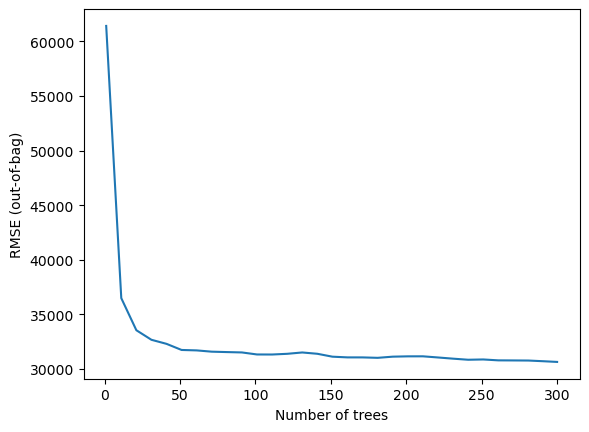

In [25]:
import matplotlib.pyplot as plt
logs = rf.make_inspector().training_logs()
plt.plot([log.num_trees for log in logs], [log.evaluation.rmse for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("RMSE (out-of-bag)")
plt.show()

In [26]:
inspector = rf.make_inspector()
inspector.evaluation()

Evaluation(num_examples=1009, accuracy=None, loss=None, rmse=30656.28150566971, ndcg=None, aucs=None, auuc=None, qini=None)

In [27]:
evaluation = rf.evaluate(x=valid_ds,return_dict=True)

for name, value in evaluation.items():
  print(f"{name}: {value:.4f}")

1/1 [==============================] - 1s 651ms/step - loss: 0.0000e+00 - mse: 698255104.0000
loss: 0.0000
mse: 698255104.0000


In [28]:
print(f"Available variable importances:")
for importance in inspector.variable_importances().keys():
  print("\t", importance)

Available variable importances:
	 SUM_SCORE
	 NUM_NODES
	 INV_MEAN_MIN_DEPTH
	 NUM_AS_ROOT


In [29]:
inspector.variable_importances()["NUM_AS_ROOT"]

[("OverallQual" (1; #62), 104.0),
 ("ExterQual" (4; #22), 61.0),
 ("Neighborhood" (4; #59), 39.0),
 ("GarageCars" (1; #32), 37.0),
 ("GrLivArea" (1; #38), 17.0),
 ("GarageArea" (1; #31), 16.0),
 ("KitchenQual" (4; #44), 10.0),
 ("BsmtQual" (4; #14), 8.0),
 ("TotalBsmtSF" (1; #73), 3.0),
 ("1stFlrSF" (1; #0), 2.0),
 ("YearBuilt" (1; #76), 2.0),
 ("GarageYrBlt" (1; #37), 1.0)]

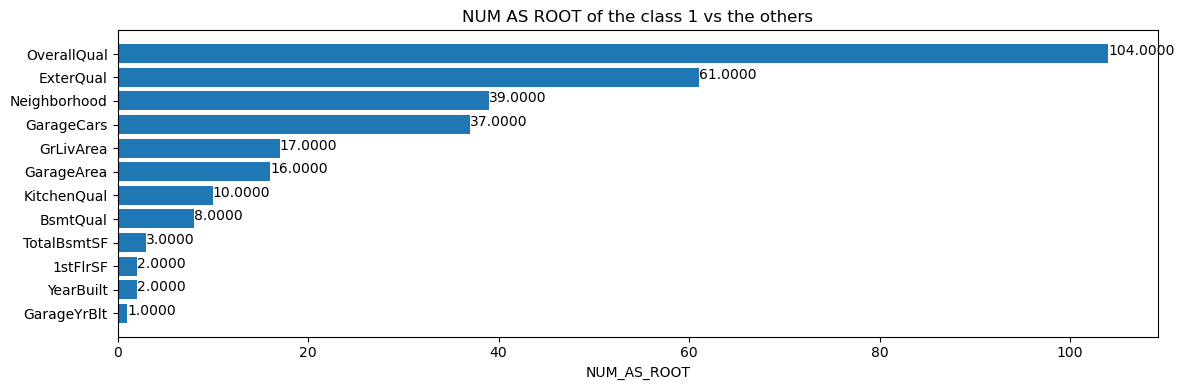

In [30]:
plt.figure(figsize=(12, 4))

# Mean decrease in AUC of the class 1 vs the others.
variable_importance_metric = "NUM_AS_ROOT"
variable_importances = inspector.variable_importances()[variable_importance_metric]

# Extract the feature name and importance values.
#
# `variable_importances` is a list of <feature, importance> tuples.
feature_names = [vi[0].name for vi in variable_importances]
feature_importances = [vi[1] for vi in variable_importances]
# The feature are ordered in decreasing importance value.
feature_ranks = range(len(feature_names))

bar = plt.barh(feature_ranks, feature_importances, label=[str(x) for x in feature_ranks])
plt.yticks(feature_ranks, feature_names)
plt.gca().invert_yaxis()

# TODO: Replace with "plt.bar_label()" when available.
# Label each bar with values
for importance, patch in zip(feature_importances, bar.patches):
  plt.text(patch.get_x() + patch.get_width(), patch.get_y(), f"{importance:.4f}", va="top")

plt.xlabel(variable_importance_metric)
plt.title("NUM AS ROOT of the class 1 vs the others")
plt.tight_layout()
plt.show()

In [32]:
test_file_path = "data/house-prices-advanced-regression-techniques/test.csv"
test_data = pd.read_csv(test_file_path)
ids = test_data.pop('Id')

test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(
    test_data,
    task = tfdf.keras.Task.REGRESSION)

preds = rf.predict(test_ds)
output = pd.DataFrame({'Id': ids,
                       'SalePrice': preds.squeeze()})

output.head()

2/2 [==============================] - 1s 70ms/step


,Id,SalePrice
0,1461,126478.671875
1,1462,153429.218750
2,1463,179195.656250
3,1464,182829.234375
4,1465,210241.921875


In [34]:
sample_submission_df = pd.read_csv('data/house-prices-advanced-regression-techniques/sample_submission.csv')
sample_submission_df['SalePrice'] = rf.predict(test_ds)
# sample_submission_df.to_csv('/kaggle/working/submission.csv', index=False)
sample_submission_df.head()


2/2 [==============================] - 0s 69ms/step


,Id,SalePrice
0,1461,126478.671875
1,1462,153429.218750
2,1463,179195.656250
3,1464,182829.234375
4,1465,210241.921875
